# Introduction

These are the instructions for peak calling the ATAC data on _individual cell types + conditions_ to show enrichment of eQTLs. Note that we used the standard archR workflow to call peaks to perform LSI and generate the UMAP, but we additionally call peaks separately here to show sample-specific effects. This describes the overall process of taking the `possorted_bam.bam`s from ATAC cellranger and making specific BAMs based on covariates, then running MACS2 on these BAMs.

# Setup

In [61]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pysam
from joblib import Parallel, delayed
from multiprocessing import cpu_count

import warnings
import itertools as it
import json
import pickle as pkl
import os

import pybedtools

# from nero import Harmonia
# from nero import Nero as nr

Here I use two different mountpoints for two different volumes. I create `mountpoint2` to store the BAMs and cell barcode text files since they take up 100s of GiBs. Once the work on the BAMs is done, I bring the data back to `mountpoint1` to run macs2, since the outputs of this are generally smaller and more portable.

In [3]:
mountpoint = '/data/clue/'
prefix_atac = mountpoint + 'amo/atac/'

In [5]:
mountpoint2 = '/data/clue2/'

In [6]:
path = prefix_atac + 'h5ads/concat_5.h5ad'
# path = mountpoint2 + 'h5ads/concat_5.h5ad'

# concat_raw.write_h5ad(path)
concat_raw = sc.read_h5ad(path) 

# Split BAMs by `chr`

First, split each BAM into it's chromosomes to take advantage of operating on a machine with multiple processeors.
I did this using:

```
$: bamtools split -in possorted_bam.bam -reference
```

This created many BAMs based on each unique chromosome in the file. I then used the command line to just organize into dirs with autosomes and non-autosomes.

```
$: ls
autosomes    other_chrs

$: ls *
autosomes/possorted_bam.REF_chr1.bam
autosomes/possorted_bam.REF_chr10.bam
autosomes/possorted_bam.REF_chr11.bam
autosomes/possorted_bam.REF_chr12.bam
.
.
.
other_chrs/possorted_bam.REF_chr11_KI270721v1_random.bam
other_chrs/possorted_bam.REF_chr14_GL000009v2_random.bam
other_chrs/possorted_bam.REF_chr14_GL000194v1_random.bam
other_chrs/possorted_bam.REF_chr14_GL000225v1_random.bam
.
.
.

```

Then extract the cell barcodes from each BAM and split according to chromosome.

In [36]:
bams = dict()

In [57]:
bam_prefix = mountpoint2 + 'bams/'

In [ ]:
for well in tqdm(range(1, 6)):
    bams[well] = dict()
    unsplit_bam_path = bam_prefix + 'orig/well%s/outs/by_chr/autosomes/possorted_bam.bam' % well
    std_out = !samtools idxstats $unsplit_bam_path
    idxstats = pd.DataFrame([i.strip().split('\t') for i in std_out]).set_index(0)
    for chrom in range(1, 23):
        bams[well][chrom] = dict()
        bam_path = bam_prefix + 'orig/well%s/outs/by_chr/autosomes/possorted_bam.REF_chr%d.bam' % (well, chrom)
        bams[well][chrom]['path'] = bam_path 
        bams[well][chrom]['total_num'] = idxstats.loc['chr%d' % chrom, [2, 3]].astype(int).sum()

In [92]:
num_jobs = cpu_count() - 2
num_jobs

30

In [ ]:
def extract_bcs(chrom):
    bams[well][chrom]['bam'] = pysam.AlignmentFile(bams[well][chrom]['path'], "r")
    with open(bam_prefix + 'orig/well%d/outs/bcs/chr%d.txt' % (well, chrom), 'w') as file: 
        for s in bams[well][chrom]['bam']:
            try:
                file.write(s.get_tag('CB') + '\n')
            except KeyError:
                file.write('nan\n')
    return

In [ ]:
well = 1
Parallel(n_jobs=num_jobs)(delayed(extract_bcs)(chrom) for chrom in range(1,23));

In [ ]:
well = 2
Parallel(n_jobs=num_jobs)(delayed(extract_bcs)(chrom) for chrom in range(1,23));

In [ ]:
well = 3
Parallel(n_jobs=num_jobs)(delayed(extract_bcs)(chrom) for chrom in range(1,23));

In [ ]:
well = 4
Parallel(n_jobs=num_jobs)(delayed(extract_bcs)(chrom) for chrom in range(1,23));

In [ ]:
well = 5
Parallel(n_jobs=num_jobs)(delayed(extract_bcs)(chrom) for chrom in range(1,23));

# Split BAM by Cell Barcodes

Here I will subset according to the groups on which we ran the eQTL analysis.

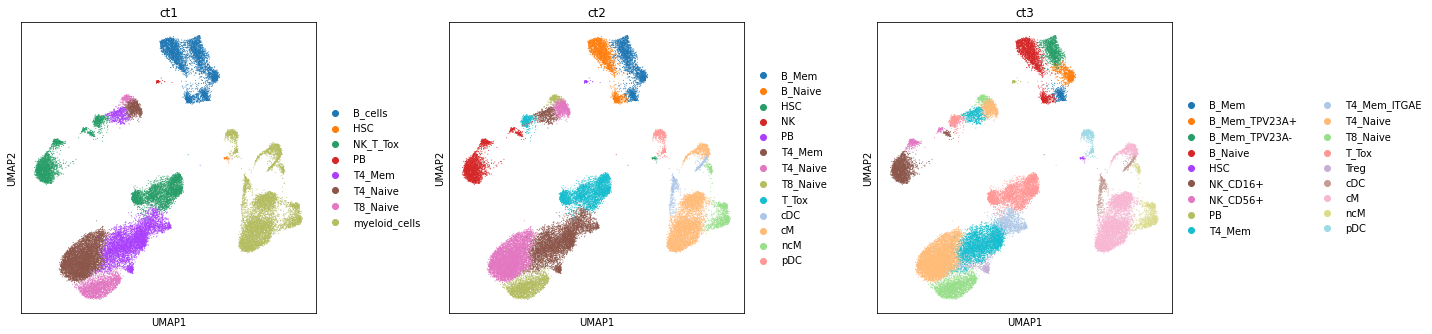

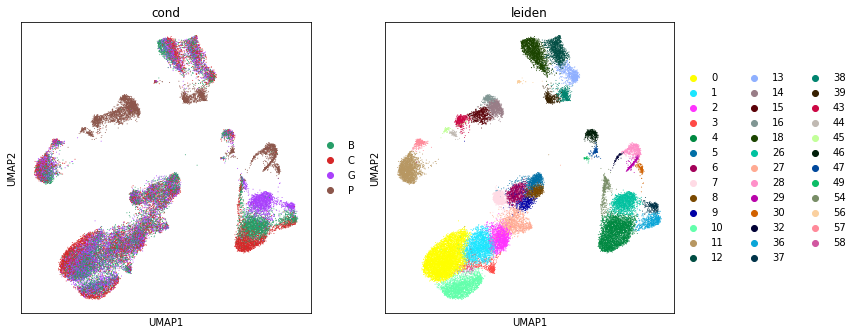

In [13]:
fig, axes = plt.subplots(1,3, figsize=(20,4.75))
for ct_type, ax in zip(['ct1', 'ct2', 'ct3'], np.ravel(axes)):
    sc.pl.umap(concat_raw, color=[ct_type], ax=ax, return_fig=False, show=False);
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(1,2, figsize=(12,4.75))
for key, ax in zip(['cond', 'leiden'], np.ravel(axes)):
    sc.pl.umap(concat_raw, color=[key], ax=ax, return_fig=False, show=False);
plt.tight_layout()
plt.show()

In [22]:
ct4 = concat_raw.obs['ct2'].astype(str).copy() # copy the initial columns

# rename T4 Memory and Effector cells to be consistent with labels from production run
ct4.replace({'T4_Mem': 'T4_EM'}, inplace=True)

# separate out T8_Mem, T_gd, and MAIT cells
ct4.loc[ct4.index[concat_raw.obs['leiden'].isin(['5', '8', '9'])]] = 'T8_Mem'
ct4.loc[ct4.index[concat_raw.obs['leiden'].isin(['6'])]] = 'T_gd'
ct4.loc[ct4.index[concat_raw.obs['leiden'].isin(['7'])]] = 'MAIT'

# separate out NKs in non-PMA/I conditions
ct4.loc[ct4.index[concat_raw.obs['leiden'].isin(['11'])]] = 'NK_CD16+'
ct4.loc[ct4.index[concat_raw.obs['leiden'].isin(['57'])]] = 'NK_CD56++'

In [23]:
concat_raw.obs['ct4'] = ct4.astype('category')

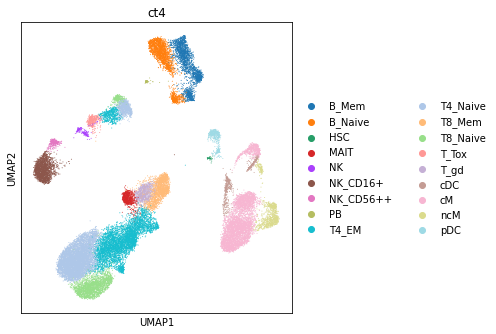

In [27]:
fig, axes = plt.subplots(1,1, figsize=(7,4.75))
for key, ax in zip(['ct4'], np.ravel(axes)):
    sc.pl.umap(concat_raw, color=[key], ax=ax, return_fig=False, show=False);
plt.tight_layout()
plt.show()

In [28]:
def freq_table(adata, cols):
    '''
    Make a frequency table of two different columns in the .obs of the adata
    object. Returns a df with the number of observations per combination of
    values from the two columns.
    
    `adata`: annotated data matrix
    `cols`: 2-tuple of the two columns of adata.obs to count
    
    returns: pd.DataFrame of frequencies
    '''
    c1, c2 = cols
    return adata.obs.groupby([c1, c2]).size().rename('count').reset_index(c2).pivot(columns=c2)

In [30]:
freq_table(concat_raw, ['ct4', 'cond'])

count                 
cond          B     C     G    P
ct4                             
B_Mem       618   593   565  435
B_Naive     634   507   598  399
HSC          20     6    11    2
MAIT        262   206   228    0
NK            0     0     1  178
NK_CD16+    669   578   625    3
NK_CD56++    71    85   114    2
PB           15    24    14    5
T4_EM      1954  1521  1824  532
T4_Naive   2073  1752  2228  863
T8_Mem      727   492   587    4
T8_Naive    834   598   794  269
T_Tox         0     2     0  395
T_gd        287   256   238    0
cDC         148   113   104  226
cM         1798  1463  1356  576
ncM         361   234   259  126
pDC         146    94   118  127

Because of low cell numbers, I'm going to pick out a few cell types and conditions for the enrichment validation.

In [67]:
concat_raw.obs['cond_ct'] = concat_raw.obs['cond'].str[:] + '_' + concat_raw.obs['ct4'].str[:]
cond_cts = ['_'.join([cond, ct]) for cond, ct in (it.product(['C', 'G', 'B'], ['T4_Naive', 'T8_Naive', 'T4_EM', 'T8_Mem', 'NK_CD16+', 'cM', 'B_Naive', 'B_Mem']))]

Create `bc_dict` mapping the bcs to their `cond_ct`.

In [53]:
bc_dict = dict()
for well in range(1, 6):
    bc_dict[well] = dict()
for bc, cond_ct in tqdm(concat_raw.obs['cond_ct'].iteritems()):
    bc_dict[int(bc[-1])][bc[:16] + '-1'] = cond_ct

Split the BAMs according to their `cond_cts`:

In [94]:
def split_bams(well, chrom):
    split_bams_dict = dict()
    bam_path = bam_prefix + 'orig/well%s/outs/by_chr/autosomes/possorted_bam.REF_chr%d.bam' % (well, chrom)
    inbam = pysam.AlignmentFile(bam_path, "rb")
    try:
        os.mkdir(bam_prefix + 'split/well%s/chr%d' % (well, chrom))
    except FileExistsError:
        pass
    for cond_ct in cond_cts:
        split_bams_dict[cond_ct] = pysam.AlignmentFile(bam_prefix + 'split/well%s/chr%d/%s.bam' % (well, chrom, cond_ct), "wb", template=inbam)    
    bcs_fname = bam_prefix + 'orig/well%d/outs/bcs/chr%d.txt' % (well, chrom)
    with open(bcs_fname, 'r') as bcs_file:
        for s, bc in zip(inbam, bcs_file):
            try:
                split_bams_dict[bc_dict[well][bc.strip()]].write(s)
            except KeyError: # there are cell barcodes in the BAMs that didn't make it to the final h5ad
                continue
    for cond_ct in cond_cts:
        split_bams_dict[cond_ct].close()
    return

In [95]:
Parallel(n_jobs=num_jobs)(delayed(split_bams)(well, chrom) for well, chrom in tqdm(list(it.product(range(1, 6), range(1,23)))));

# Merge BAMs

Now I need to merge all the BAMs from across the different chromsomes back together. First export the list of `cond_cts`.

In [98]:
with open(mountpoint2 + 'cond_cts.txt', 'w') as file:
    for cond_ct in cond_cts:
        file.write(cond_ct + '\n')

Use that to compile all the paths to all the individual BAMs.

```
$: cd $mountpoint2
$: cd bams; mkdir paths;
$: cat ${mountpoint2}/cond_cts.txt | while read line; do find -type f -name "${line}.bam" > paths/${line}.txt; done;
```


Then, run `samtools merge` to merge all the BAMs. I run this in a screen since it may take a while:

```
$: mkdir merged
$: cat ${mountpoint2}/cond_cts.txt | while read line; do samtools merge -b paths/${line}.txt -@ 30 merged/${line}.bam; done;
```


Also create a single BAM of all the control cells for showing broad enrichment:
```
$: cd merged/
$: vim C_merge.txt

(vim)

C_T4_Naive.bam
C_T8_Naive.bam
C_T4_EM.bam
C_T8_Mem.bam
C_NK_CD16+.bam
C_B_Naive.bam
C_B_Mem.bam
C_cM.bam

(wq!)

$: samtools merge -b C_merge.txt -@ 15 C_all.bam
```

# Run MACS2

For this, we use the `macs2` installation that was done as part of the archR installation, so we activate the environment at the command line and run it. I do this in a `screen` to run them concurrently, changing out the cell type for each new run. The example below is for `T4_Naive`, but I run this on all 8 cell types for the control condition.

```
$: cd /data/clue2/macs2/
$: conda activate archR_R
(archR_R) $: macs2 callpeak -t /data/clue2/bams/merged/C_T4_Naive.bam -c /data/clue2/bams/merged/C_T8_Naive.bam /data/clue2/bams/merged/C_T8_Mem.bam /data/clue2/bams/merged/C_NK_CD16+.bam /data/clue2/bams/merged/C_cM.bam /data/clue2/bams/merged/C_T4_EM.bam /data/clue2/bams/merged/C_B_Naive.bam /data/clue2/bams/merged/C_B_Mem.bam --shift -75 --extsize 150 --nomodel --call-summits --nolambda --keep-dup all -q 0.05 --outdir C_T4_Naive}/ --name C_T4_Naive
.
.
.
```


```
(archR_R) $: macs2 callpeak -t /data/clue2/bams/merged/C_all.bam --shift -75 --extsize 150 --nomodel --call-summits --nolambda --keep-dup all -q 0.05 --outdir C_all/ --name C_all
```